# Statistical Seismology and the Parkfield region
We will do some basic statistical seismology to see how the Parkfield inter-earthquake times are distributed. Does the distribution follow the Exponential model of earthquake timing or does the sequence follow a Gaussian model?

The Gaussian (normal model) assumes earthquakes happen periodically. The Exponential model assumes earthquakes follow a Poisson process.  The Gutenberg-Richter law states that magnituted of earthquakes in a given region over a given period of time are Exponentially distributed.

In statistical seismology, the location parameter is called the completeness threshold (the magnitude, m$_{t}$, above which all earthquakes in a region can be detected/measured). The optimal value of the parameter is m - m$_{t}$. For historic reasons, seismologists do not use the mean directly. They use the mean x of the natural logarithim of ten and it is called the b-value: 
<br>b = ( $\bar{m}$ - m$_{t}$) $\cdot$ log(10)</br>

We will be using bootstrap samples of the data because we have a limited number of observations.

In [45]:
# import packages
import pandas as pd
import numpy as np
import dc_stat_think as dcst
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,10)

## EDA of Parkfield earthquake magnitudes

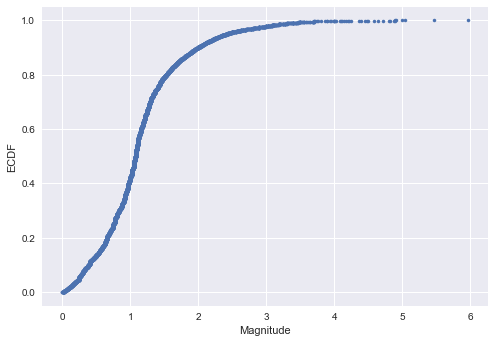

In [46]:
# read in the data for Parkfield earthquakes: parkfield
parkfield = pd.read_csv('parkfield_earthquakes_1950-2017.csv', encoding='utf-8')

# Create an array of the magnitudes: mags
mags = np.array(parkfield['mag'])

# Generate a plot of the ECDF of the magnitudes
plt.style.use('seaborn')
plt.plot(*dcst.ecdf(mags), marker='.', linestyle='none')
plt.xlabel('Magnitude')
plt.ylabel('ECDF')
plt.show()

The plot shows a distinct roll-off at magnitudes below 1.0

In [22]:
# Define a function that computes the b-value: b_value
def b_value(mags, mt, perc, n_reps):
    """Compute the b-value and optionally its confidence interval"""
    
    # Extract the magnitudes above the completeness threshold: m
    m = mags[mags >= mt]
    
    # Compute the b-value: b
    b = np.mean((m) - mt) * np.log(10)
    
    # Draw the bootstrap replicates: m_bs_reps
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m, np.mean, size=n_reps)
        
        # Compute the b-value from the replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)
        
        # Compute the confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps, perc)
        
        return b, conf_int

The ECDF is effective at exposing roll-off. Because there are plenty of earthquakes above magnitude 3.0, we can use mt=3

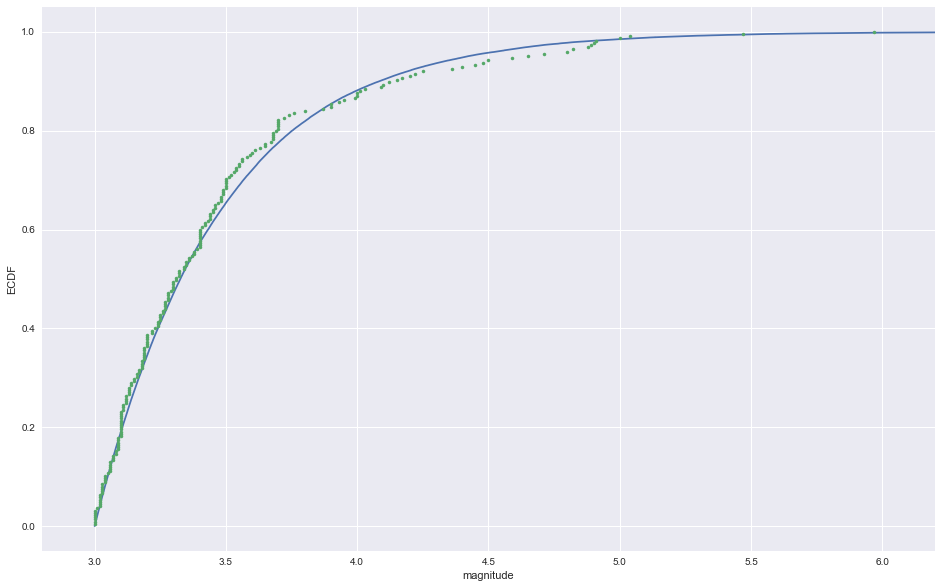

b-value: 1.08
95% conf int: [ 0.93495188  1.24063285]


In [52]:
mt = 3
# Compute  the b-value for the Parkfield region

# Compute the b-value and 95% confidence interval: b, conf_int
b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)

# Generate 100,000 samples for the theoretical ECDF: m_theor
m_theor = np.random.exponential(b/np.log(10), size=100000)+mt

# Plot the theoretical CDF
plt.figure(figsize=(16, 10))
_ = plt.plot(*dcst.ecdf(m_theor))

# Plot the ECDF (slicing mags >= mt)
_ = plt.plot(*dcst.ecdf(mags[mags>=mt]), marker='.', linestyle='none')

# Label and show the plot

_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
_ = plt.xlim(2.8, 6.2)
plt.show()

# Report the results
print('b-value: {0:.2f}'.format(b))
print('95% conf int:', conf_int)

The Parkfield sequence seems to follow the Gutenberg-Richter law very well (b-value: 1.08). The b-value 1 is typical of regions along a fault zone.

## Time gaps between earthquakes
Now, we need to examine the timing of major earthquakes. There are two models for inter-earthquake timing: the Exponentional model, which assumes earthquakes happen like a Poisson process; and the Gaussian model, which assumes earthquakes happen periodically.

There are very few observations for major earthquakes in  our dataset, so we need to generate some theoretical distributions for the time gaps between earthquakes and compare their CDF to the ECDF.

The mean and standard deviation are the best estimates for the parameters of the theoretical distributions

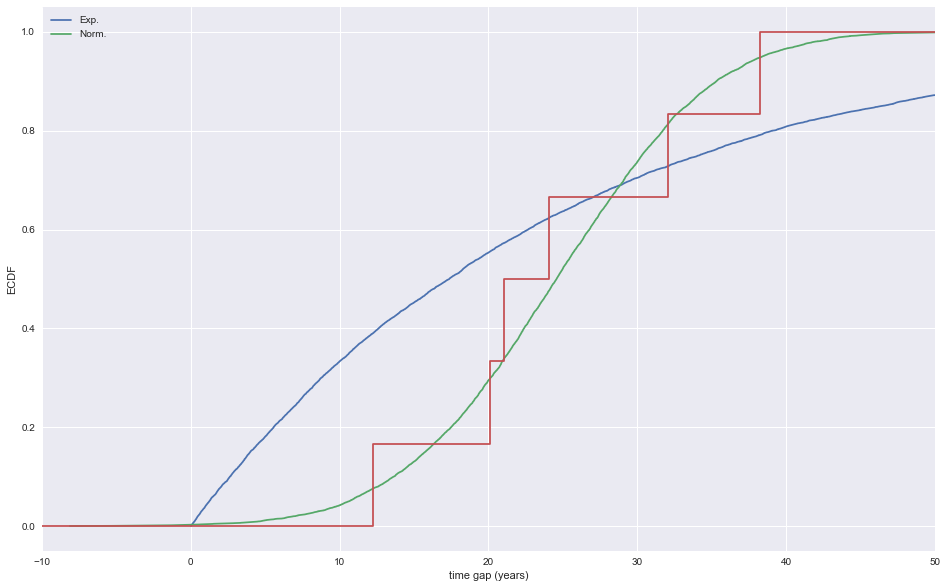

In [54]:
# Create an array of time gaps between major earthquakes in units of years: time_gap
time_gap = np.array([24.06570842, 20.07665982, 21.01848049, 12.24640657, 32.05475702,
       38.2532512])

# Compute the mean interearthquake time gap: mean_time_gap
mean_time_gap = np.mean(time_gap)

# Compute the standard deviation of the time gaps: std_time_gap
std_time_gap = np.std(time_gap)

# Generate a theoretical Exponential distribution of timings: time_gap_exp
time_gap_exp = np.random.exponential(mean_time_gap, size=10000)

# Generate a theoretical Normal distribution of timings: time_gap_norm
time_gap_norm = np.random.normal(mean_time_gap, std_time_gap, size=10000)

# Plot the theoretical CDFs
plt.figure(figsize=(16, 10))
_ = plt.plot(*dcst.ecdf(time_gap_exp))
_ = plt.plot(*dcst.ecdf(time_gap_norm))

# Plot the formal Parkfield ECDF
_ = plt.plot(*dcst.ecdf(time_gap, formal=True, min_x=-10, max_x=50))

# Add legend
_ = plt.legend(('Exp.', 'Norm.'), loc='upper left')

# Label axes, set limits and show plot
_ = plt.xlabel('time gap (years)')
_ = plt.ylabel('ECDF')
_ = plt.xlim(-10, 50)
plt.show()



The Gaussian model appears to best describe the observed data.

Can either model help us predict when the next Parkfield earthquake will occur? The best estimate for both models is given by the mean time gap of 24.62 years. If that is accurate and the last big quake occured September 27, 2009 then the next big earthquake would be in 2029.

The next step in analysis is to compute the 95% confidence interval on when the next quake will occur for both models.

In [49]:
# Draw 100,000 samples from the the Exponential distribution: exp_samples
exp_samples = np.random.exponential(mean_time_gap, size=100000)

# Draw 100,000 samples from the Normal distribution: norm_samples
norm_samples = np.random.normal(mean_time_gap, std_time_gap, size=100000)

# Slice out samples that are greater than today - last_quake: exp_samples, norm_samples
last_quake = 2004.74
today = 2018.598182224834
exp_samples = exp_samples[exp_samples > today - last_quake]
norm_samples = norm_samples[norm_samples > today - last_quake]

# Compute the confidence intervals with medians: conf_int_exp, conf_int_norm
conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5]) + last_quake
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) + last_quake

# Print the results
print('Exponential: ', conf_int_exp)
print('     Normal: ', conf_int_norm)


Exponential:  [ 2019.2172014   2035.84982124  2108.35220792]
     Normal:  [ 2019.60802354  2030.43725455  2046.12588727]


The Gaussian model says the next earthquake is almost sure to be in the next few decades. The Exponential model says it will be a bit longer than that before the next major earthquake hits the Parkfield region.

## How are the Parkfield inter-earthquake times distributed?
Knowing how the time between major earthquakes is distributed makes a big difference in assessing when the next quake will strike. In the mid 1980s seismologoists conducted the "Parkfield earthquake prediction experiment." Beginnning with observations from 1966 forward and essentially assuming a Gaussian model for the sequence of earthquakes, the seismologists predicted that there was a 95% chance that major (magnitude $\geq$ 6) earthquake would occur around 1988 and certainly no later than 1996. No major seismic activity occured on the Parkfield segment of the fault until September of 2004$^{1}$.

Can the Exponential model be dismissed in favor of the Gaussian model?

Hypothesis: The inter-earthquake times for the Parkfield sequence are Exponentially distributed and paramaterized with a mean and standard deviation calculated from the observed data

Test statistic: The Kolmorogov-Smirnov statitstic (K-S statistic) can be used to measure how close an ECDF is to the theoretical Normal CDF. The K-S statistic will be used to measure the maximal distance between the ECDF and the Normal distribution.

At least as extreme as: The simulated K-S statistic$\geq$the observed K-S statistic.

1: Bakun, W. H.; Lindh, A. G. (16 August 1985), "The Parkfield, California, Earthquake Prediction Experiment", Science, 229 (4714): 619–624,

In [60]:
# T-test the null hypothesis

# Draw 10,000 replicates from the Exponential distribution: x_f
x_f = np.random.exponential(mean_time_gap, size=10000)

# Compute the K-S statistic using x_f and the actual time gap: d
d = dcst.ks_stat(time_gap, x_f)

# Draw 10,000 K-S replicates from the Exponential Distribution: reps
reps = dcst.draw_ks_reps(len(time_gap), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

# Compute and print the p-value: p_val
p_val = np.sum(reps >= d) / 10000
print('p=', p_val)

p= 0.2459


The p-value indicates that it is not outsided of the realm of possibility that the Parkfield sequence follows a Poisson process. It should, however, be noted that this only means the observed sequence is not incongruous with an Exponential model.